#  EDA (Exploratory Data Analysis) 📊

## 0. Import and Settings

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data with correct headers 

Before beginning any EDA, an essential aspect is correctly reading and loading the data. In both CSV files, the headers are missing, so we opened *census_income_metadata.txt* to extract and reconstruct the column names.

In [6]:
with open ('../census_income_metadata.txt') as f:
    lines = f.readlines()

col_names = []
# starting from line 142 is where the columns names can be extracted
column_names_lines =lines[142:]
for l in column_names_lines:
    # this prevents from adding the columns instance weight twice
    if l.startswith('|'):
        continue
    # chnages "class of worker" => "class_of_worker"
    final_col_name = l.split(":", 1)[0].strip().replace(" ", "_")
    col_names.append(final_col_name)

# the columns income was missing
col_names.append('income')

# sanity check
len(col_names)

42

We observe that both the training and test files contain the same number of columns, reflecting the original ~66/33% split described in the metadata. However, since this predefined split is arbitrary and not based on time, leakage risks, or any domain constraints, it is not necessary to preserve it for analysis. For EDA purposes, we therefore merge both datasets and explore the full data as a whole. Later, for modeling, we will replace the original split with a more robust and commonly used 70/10/20 train/validation/test partition. This new split will be stratified to preserve the strong class imbalance present in the original data (approximately 93% earning <50k and 7% earning >50k), ensuring consistent class proportions across all subsets and enabling stable model evaluation.


In [12]:
# import you own file for Census_Income_Data.csv (above 100MB so can not upload to github)
train_df = pd.read_csv('../csv_preparation/Census_Income_Data.csv',header=None, names= col_names, index_col=False)
print(f"Train set shape : {train_df.shape}")
test_df = pd.read_csv('../csv_preparation/Census_Income_Test.csv',header=None, names=col_names,index_col=False)
print(f"Test set shape : {test_df.shape}")

print(train_df['income'].value_counts()/len(train_df)*100)
print(test_df['income'].value_counts()/len(test_df)*100)

Train set shape : (199523, 42)
Test set shape : (99762, 42)
income
- 50000.    93.794199
50000+.      6.205801
Name: count, dtype: float64
income
- 50000.    93.799242
50000+.      6.200758
Name: count, dtype: float64


In [13]:
df_full = pd.concat([train_df, test_df], ignore_index=True)
df_full

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299280,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1708.85,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
299281,61,Private,8,36,11th 

## 2. Initail Sanity Check

The .info() function helps clarify the types of each column so we can apply appropriate feature adjustments. Some variables are currently stored as numerical values but should in fact be treated as categorical codes. For example, detailed_occupation_recode and detailed_industry_recode appear as numeric columns, but their numeric values do not represent an order or magnitude—code “24” is not “greater” or more meaningful than code “7.” They simply map to distinct occupation/industry categories.

In contrast, truly numerical features—such as age, wage_per_hour, or weeks_worked_in_year—do carry meaningful ordering, where higher values correspond to greater magnitude and may influence the likelihood of earning more or less than $50K.

To proceed, we first inspect all non-string features and assign them the correct data type. Columns where the numeric ranking has semantic meaning remain numerical, while fields where numbers are just identifiers (e.g., industry or occupation codes) are cast to categorical. This ensures both proper EDA and more accurate modeling later on.


In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299285 entries, 0 to 299284
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         299285 non-null  int64  
 1   class_of_worker                             299285 non-null  object 
 2   detailed_industry_recode                    299285 non-null  int64  
 3   detailed_occupation_recode                  299285 non-null  int64  
 4   education                                   299285 non-null  object 
 5   wage_per_hour                               299285 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  299285 non-null  object 
 7   marital_stat                                299285 non-null  object 
 8   major_industry_code                         299285 non-null  object 
 9   major_occupation_code                       299285 non-null  object 
 

In [15]:
df_full['year'].value_counts()

year
94    149643
95    149642
Name: count, dtype: int64

In [16]:
# list of within the numerical columns that will keep as a continous and numeurcal feature

keep_numeric_cols = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year",
]

# These two columns are dropped because:
# - 'year' has only two values and does not provide predictive signal for the target ('income').
# - 'instance_weight' represents the number of people in a sampling unit; it is relevant for survey
#   weighting but does not help the predictive model and would introduce noise. 
drop_cols = ["instance_weight", "year"]
target_col = ['income']

# All other columns are therefore categoricals
categorical_cols = [ col for col in df_full.columns 
                    if col not in keep_numeric_cols + drop_cols + target_col]

df_full[categorical_cols] = df_full[categorical_cols].astype(str)

# to compare with above
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299285 entries, 0 to 299284
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         299285 non-null  int64  
 1   class_of_worker                             299285 non-null  object 
 2   detailed_industry_recode                    299285 non-null  object 
 3   detailed_occupation_recode                  299285 non-null  object 
 4   education                                   299285 non-null  object 
 5   wage_per_hour                               299285 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  299285 non-null  object 
 7   marital_stat                                299285 non-null  object 
 8   major_industry_code                         299285 non-null  object 
 9   major_occupation_code                       299285 non-null  object 
 

In [17]:
# Throhgout the entire dataset there is not one single NaN however this does not mean that all information 
# is valuable and some NaNs can be present in our datset but through a different form, for instance as a string with "nan", "?" or "not in universe"
# The fact that there is no NaN value is always a good sign, but i can hide other information, delve on in later on.
df_full.isna().sum().sum()

np.int64(0)

Initially, I assumed duplicates might represent different people with identical characteristics, so I considered keeping them. But the dataset includes an instance_weight column, which already indicates how many people each row represents. This means each row is intended to be unique. If we keep duplicated rows, we would artificially repeat the same weighted observation and distort the data.

Since we are not using population weighting in this predictive modeling task, the instance_weight column is not needed and can be removed. Once weights are removed, duplicates provide no extra information. They simply repeat the same row and should be dropped.

All duplicates belong to the majority class (<50K). Keeping them would only increase an already large class imbalance. Removing them avoids unnecessary bias while still keeping the natural ~93/7 class distribution.

In [18]:
df_full[df_full.duplicated()]['income'].value_counts()

income
- 50000.    6735
Name: count, dtype: int64

In [19]:
# percentage of duplicated 
print(f"Perceangt of duplicated within the df: {df_full.duplicated().sum() / len(df_full) * 100}")
df_full.drop_duplicates(inplace=True)
# making sure that after dropping duplciates the proportion/disctrubtion of class remains similar 
print(df_full['income'].value_counts()/len(df_full)*100)

Perceangt of duplicated within the df: 2.2503633660223534
income
- 50000.    93.653051
50000+.      6.346949
Name: count, dtype: float64


## 3. Numerical cols Sanity Check

The df.describe() function gives basic numerical summaries (mean, min, max, quartiles). This helps verify whether values fall within a reasonable range. For example:
	•	age ranges from 0 to 90
	•	weeks_worked_in_year ranges from 0 to 52

These ranges make sense for the dataset.

However, it is also important to look at the distribution of these numerical features, whether they are normal, skewed, or heavily concentrated in certain areas. Understanding the distribution will be useful later during feature engineering, especially when selecting the right scaling method (e.g., MinMaxScaler or StandardScaler) or deciding whether a log transformation is needed. More details on this will be covered in the feature-engineering notebook.

As mentioned earlier, this notebook focuses only on EDA. Here we describe and visualize the data but do not apply any transformations or make modeling decisions yet. The goal is simply to understand the dataset so that we can make informed choices later.

In [20]:
df_full[keep_numeric_cols].describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
count,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000
mean,35.148737,56.369147,441.681617,37.697337,200.322198,2.000848,23.708146
std,22.174974,276.334763,4723.762662,272.819017,1959.711763,2.372970,24.425794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000


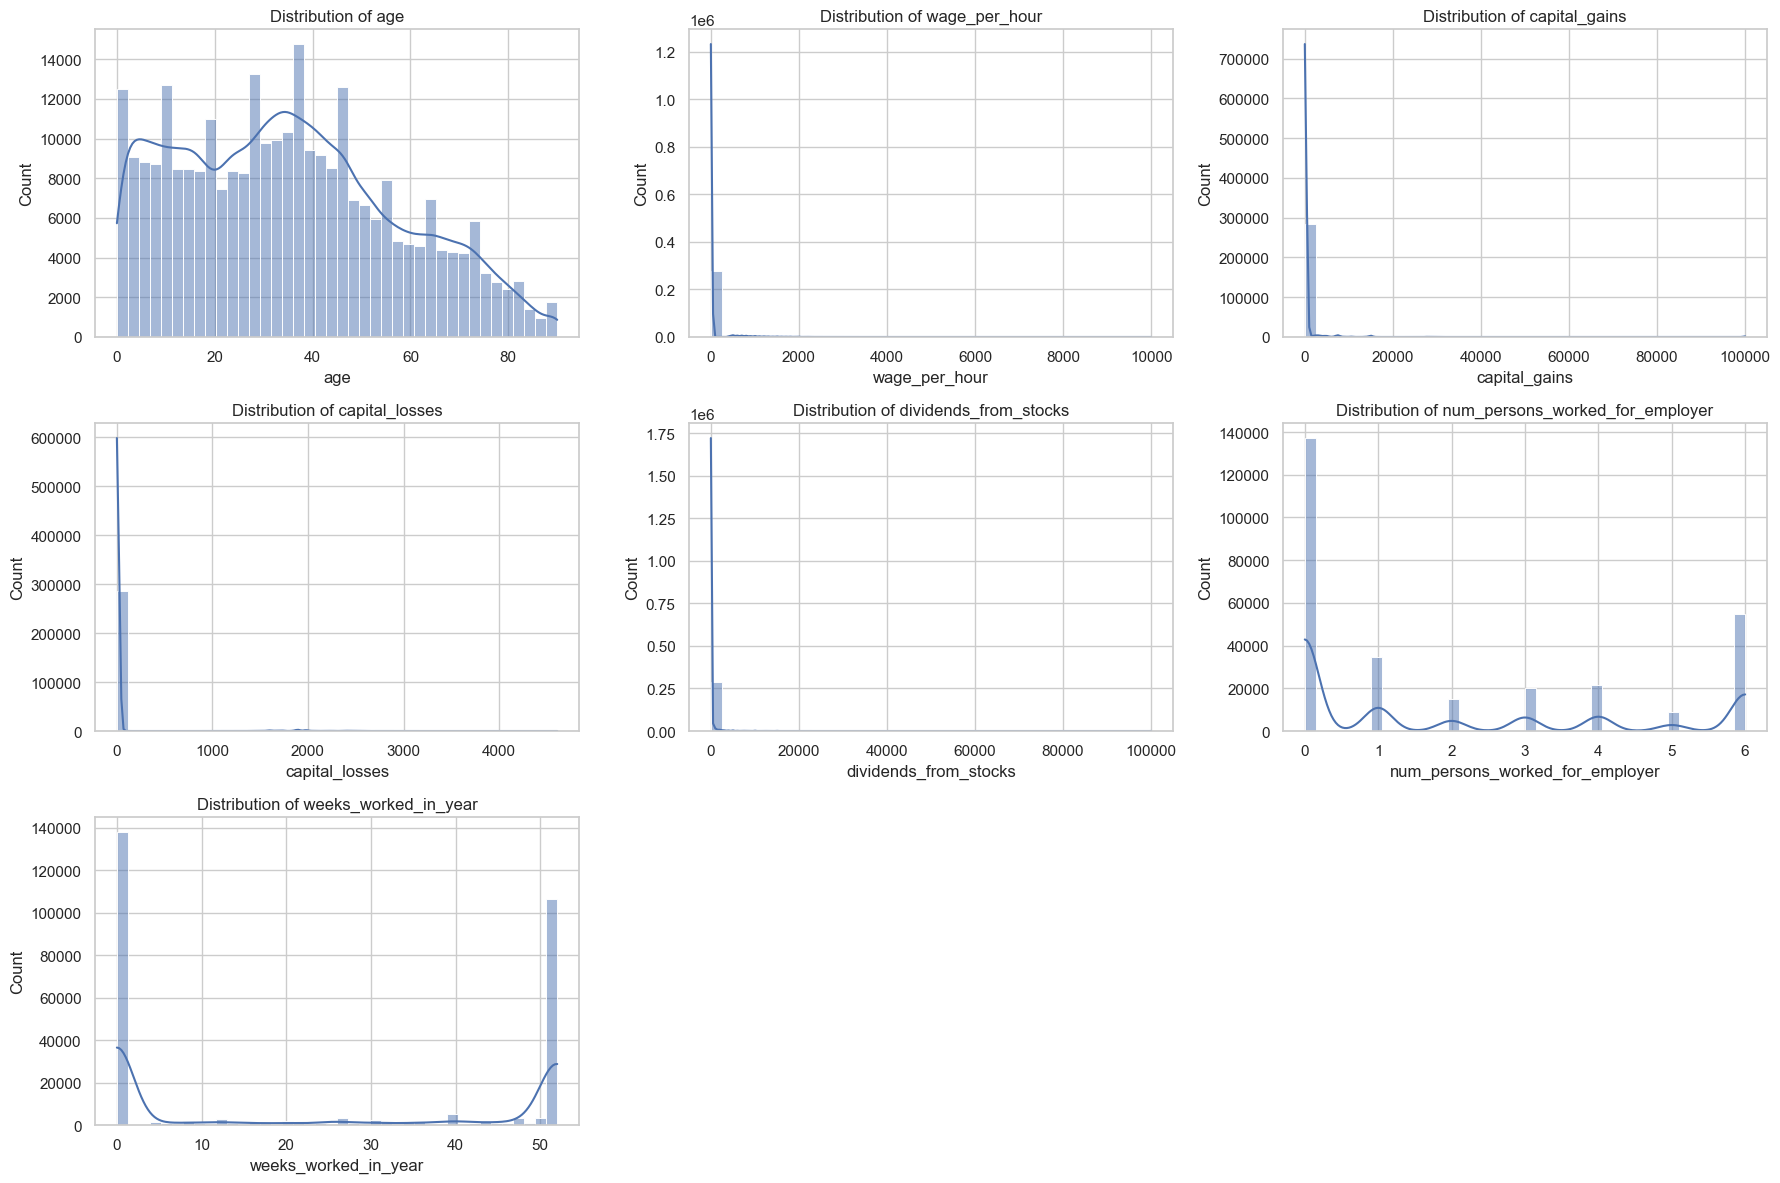

In [21]:
# This function was done with the help of ChatGPT as i struggled with the subplots
sns.set(style="whitegrid")
def plot_numeric_distributions(df, numeric_cols):
    n = len(numeric_cols) 
    cols = 3
    rows = (n + cols - 1) // cols 
    
    plt.figure(figsize=(cols * 6, rows * 4))
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        
        sns.histplot(
            df[col],
            bins=40,
            kde=True,
            edgecolor=None
        )
        
        plt.title(f"Distribution of {col}", fontsize=12)
        plt.xlabel(col)
        plt.ylabel("Count")
    
    plt.tight_layout()
    plt.show()

plot_numeric_distributions(df_full, keep_numeric_cols)

<Axes: >

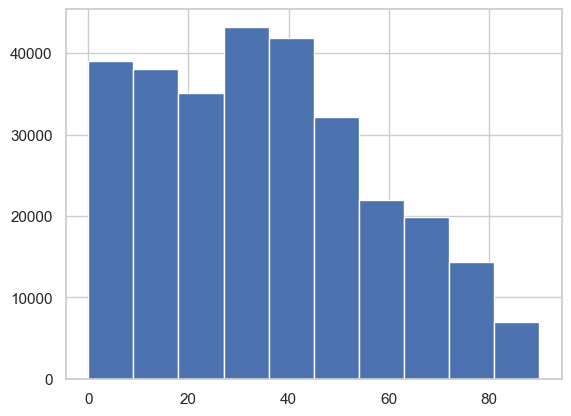

In [22]:
# in depth look at one particular numerical col for exampple
df_full['age'].hist()

To better understand how the numerical features relate to each other, we examine their Pearson correlation matrix. Pearson correlation values range from -1 to 1, where values close to 1 or -1 indicate strong linear or inverse linear relationships. Strong correlations may suggest that two features carry redundant information.

As a general rule of thumb, correlations above 0.8 or below –0.8 can be considered high enough that one of the variables might be removed or deprioritized. In this dataset, however, most numerical features show relatively low correlations (except the work-related cols), so we do not observe any pairs that are strongly linear.

Later, once the categorical variables are encoded, we will be able to compute correlations across all features, not only the numeric ones.

<Axes: >

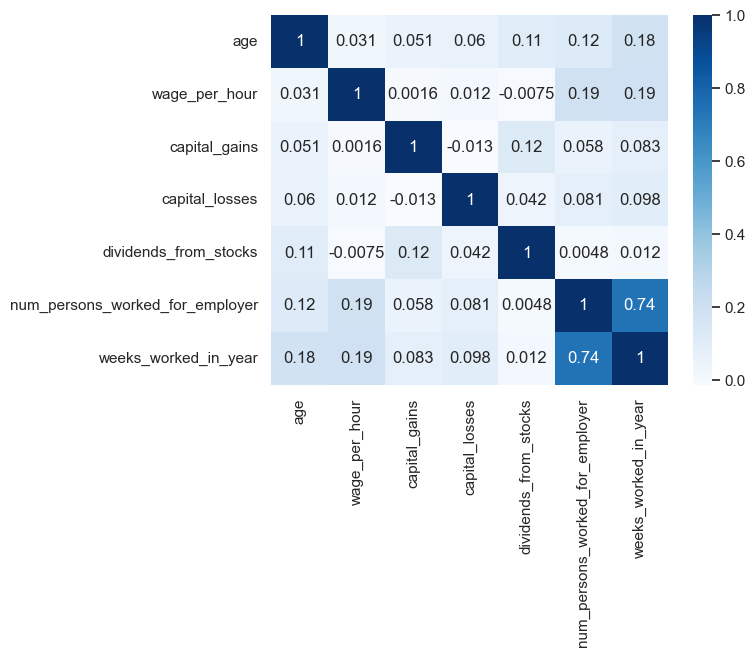

In [23]:
corr = df_full[keep_numeric_cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

##  4. Categorical Columns

We now look more closely at the categorical columns. The goal is to understand their class distributions, the number of unique categories, and any imbalance within them. This information will help us choose the appropriate encoding method and may also highlight columns that can be dropped if they provide little useful information.

In [24]:
# First of all, for cleanliness and reproducibility, i remove all the white space 
#  ex : " not in universe " =>  "not in universe"
df_full[categorical_cols] = df_full[categorical_cols].applymap(
    lambda x: x.strip() if isinstance(x, str) else x
)

/var/folders/8t/vbvw23nj5_111hy85bf96bxh0000gn/T/ipykernel_32999/1998648224.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_full[categorical_cols] = df_full[categorical_cols].applymap(


We also observed that some categorical columns contain the value "?". This value is not informative because we do not know what it represents—it could be a missing value, an unknown category, or an error. In contrast, other ambiguous-looking categories such as "Not in universe" do have a clear meaning. For example, in the reason_for_unemployment column, "Not in universe" indicates people who are not part of the unemployment population (e.g., employed workers, students). So while "Not in universe" is a valid and useful category, "?" is not.

For this reason, columns with a high percentage of "?" values may need to be removed or handled differently, depending on how frequent the "?" entries are and whether the feature still provides useful information.

In [25]:
# percentage of categorical coumns with "?" present
(df_full[categorical_cols] == "?").sum() /len(df_full)*100

class_of_worker                                0.000000
detailed_industry_recode                       0.000000
detailed_occupation_recode                     0.000000
education                                      0.000000
enroll_in_edu_inst_last_wk                     0.000000
marital_stat                                   0.000000
major_industry_code                            0.000000
major_occupation_code                          0.000000
race                                           0.000000
hispanic_origin                                0.000000
sex                                            0.000000
member_of_a_labor_union                        0.000000
reason_for_unemployment                        0.000000
full_or_part_time_employment_stat              0.000000
tax_filer_stat                                 0.000000
region_of_previous_residence                   0.000000
state_of_previous_residence                    0.353444
detailed_household_and_family_stat             0

### ⚠️ Important code block

The code block below is useful because it provides four key pieces of information for each categorical feature:
- **The number of unique categories** -> helps for the right choice of encoding

- **Top 10 most frequent categories**-> help indentify if high number of "?" for instance

- **Target distribution per category**,  -> important for feature selection. For example, the data shows that individuals with a PhD or those working in architecture and engineering have around a 50% chance of earning more than $50K. This kind of information confirms that such features are relevant and should be kept. It also highlights meaningful disparities, such as differences in income by sex (see screenshot).

- **Presence of suspicious or unexpected values** -> helps detect categories that may need cleaning or removal.

![Screenshot 2025-11-17 at 12.04.36.png](<attachment:Screenshot 2025-11-17 at 12.04.36.png>)

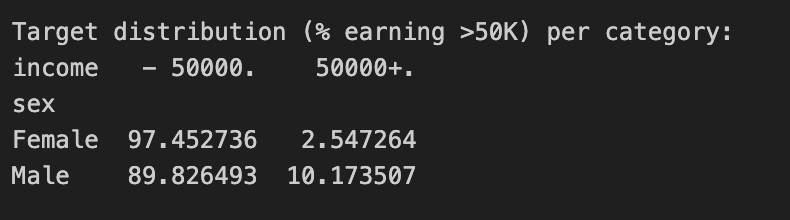

In [26]:
# Formatted with the help of ChatGPT
for col in categorical_cols:
    print("="*80)
    print(f"COLUMN: {col}")
    print(f"Unique categories: {df_full[col].nunique()}")
    print()
    
    print("Top 10 categories:")
    print(df_full[col].value_counts(normalize=True).head(10))
    print()
    
    print("Target distribution (% earning >50K) per category:")
    print(
        pd.crosstab(
            df_full[col],
            df_full["income"],
            normalize="index"
        ) * 100
    )
    print()
    
    weird = df_full[col].unique()
    weird = [w for w in weird if w.strip() in ["?", ""," ","Unknown"]]
    if weird:
        print(f"⚠️ Found suspicious categories: {weird}")
    else:
        print("No suspicious categories found.")

    print("="*80)
    print("\n")


COLUMN: class_of_worker
Unique categories: 9

Top 10 categories:
class_of_worker
Not in universe                   0.490921
Private                           0.369431
Self-employed-not incorporated    0.043487
Local government                  0.039703
State government                  0.021853
Self-employed-incorporated        0.016790
Federal government                0.014801
Never worked                      0.002194
Without pay                       0.000820
Name: proportion, dtype: float64

Target distribution (% earning >50K) per category:
income                           - 50000.    50000+.
class_of_worker                                     
Federal government              79.884527  20.115473
Local government                88.936720  11.063280
Never worked                    99.688474   0.311526
Not in universe                 99.060709   0.939291
Private                         89.814669  10.185331
Self-employed-incorporated      65.736971  34.263029
Self-employed-not incor

In [ ]:
# this file is then saved as a pickle file, later loaded in the nex ipynb, as a .csv format do not hold 
# account of the changes regarindg the data type of the column for instance.

# this file is above 100 MB so please download from ...
# df_full.to_pickle("csv_preparation/df_post_eda.pkl")